# eQTL enrichment of gene groups

### Background

Enrichment for eQTLs of genes

### Imports

In [1]:
library(ggplot2)
library(extrafont)
library(scales)
library(reshape2)
library(forcats)
library(cowplot)
library(patchwork)
library(ggsignif)
library(rcompanion)
library(ggtext)

Registering fonts with R


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [2]:
source("https://gist.githubusercontent.com/benmarwick/2a1bb0133ff568cbe28d/raw/fb53bd97121f7f9ce947837ef1a4c65a73bffb3f/geom_flat_violin.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Ohnologs, SSDs, singletons

### Proportion affected by eQTLs

##### Bonferroni-corrected

In [3]:
genesWitheQTLTissueCountBonferroni <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndOhnologStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9533                      Mean   : 7.669   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :24920039

In [4]:
genesWitheQTLTissueCountBonferroni$affected <- 'N'
genesWitheQTLTissueCountBonferroni[ which(genesWitheQTLTissueCountBonferroni$affectedTissues > 0),]$affected <- 'Y'

In [5]:
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9533                      Mean   : 7.669   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :24920039

In [6]:
table(genesWitheQTLTissueCountBonferroni[,c("type","affected")])

           affected
type           N    Y
  ohno       946 5604
  singleton 1079 4661
  SSD       1304 5473

In [7]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountBonferroni[,c("type","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test

data:  table(genesWitheQTLTissueCountBonferroni[, c("type", "affected")])
X-squared = 63.433, df = 2, p-value = 1.681e-14


           affected
type           N    Y
  ohno       946 5604
  singleton 1079 4661
  SSD       1304 5473

,N,Y
ohno,1143.596,5406.404
singleton,1002.174,4737.826
SSD,1183.229,5593.771


           affected
type                N         Y
  ohno      -7.937794  7.937794
  singleton  3.195034 -3.195034
  SSD        4.813476 -4.813476

In [8]:
round(5604/(5604+946), 3)

[1] 0.856

In [9]:
round(4661/(4661+1079), 3)

[1] 0.812

In [10]:
round(5473/(5473+1304), 3)

[1] 0.808

In [11]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 1.681492e-13

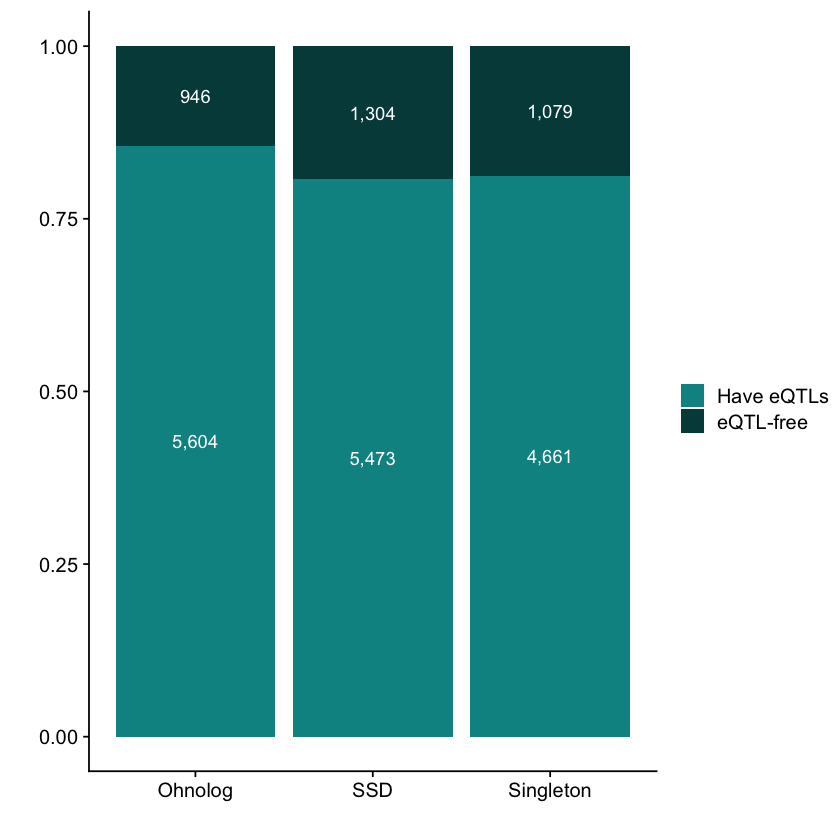

In [12]:
ohnolog_bar_chart_bonferroni <- ggplot(data=melt(table(genesWitheQTLTissueCountBonferroni[,c("type","affected")])), aes(type, value)) +
    theme_cowplot() +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        limits=c("ohno", "SSD", "singleton"),
        labels=c("Ohnolog", "SSD", "Singleton")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right") #+
#    geom_signif(
#        xmin = "ohno",
#        xmax = "singleton",
#        y_position = 1.01,
#        annotation = paste0("P=", format(p.adjust(Xsq$p.value, method="bonferroni", n=10), digits = 3)),
#        size = 0,
#        tip_length = 0)

ohnolog_bar_chart_bonferroni

##### Metasoft

In [13]:
genesWitheQTLTissueCountMetasoft <- read.csv("../../outputFiles/genesWitheQTLTissueCountMetasoftAndOhnologStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.:10.00   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median :34.00   Median :48.00   
 Mean   : 9533                      Mean   :28.96   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :249200395   Max

In [14]:
genesWitheQTLTissueCountMetasoft$affected <- 'N'
genesWitheQTLTissueCountMetasoft[ which(genesWitheQTLTissueCountMetasoft$affectedTissues > 0),]$affected <- 'Y'

In [15]:
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.:10.00   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median :34.00   Median :48.00   
 Mean   : 9533                      Mean   :28.96   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :249200395   Max

In [16]:
table(genesWitheQTLTissueCountMetasoft[,c("type","affected")])

           affected
type           N    Y
  ohno       199 6351
  singleton  385 5355
  SSD        616 6161

In [17]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountMetasoft[,c("type","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test

data:  table(genesWitheQTLTissueCountMetasoft[, c("type", "affected")])
X-squared = 209.2, df = 2, p-value < 2.2e-16


           affected
type           N    Y
  ohno       199 6351
  singleton  385 5355
  SSD        616 6161

,N,Y
ohno,412.2306,6137.769
singleton,361.2524,5378.748
SSD,426.5170,6350.483


           affected
type                 N          Y
  ohno      -13.390160  13.390160
  singleton   1.543847  -1.543847
  SSD        11.805452 -11.805452

In [18]:
round(6351/(6351+199), 3)

[1] 0.97

In [19]:
round(5355/(5355+385), 3)

[1] 0.933

In [20]:
round(6161/(6161+616), 3)

[1] 0.909

In [21]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 3.735215e-45

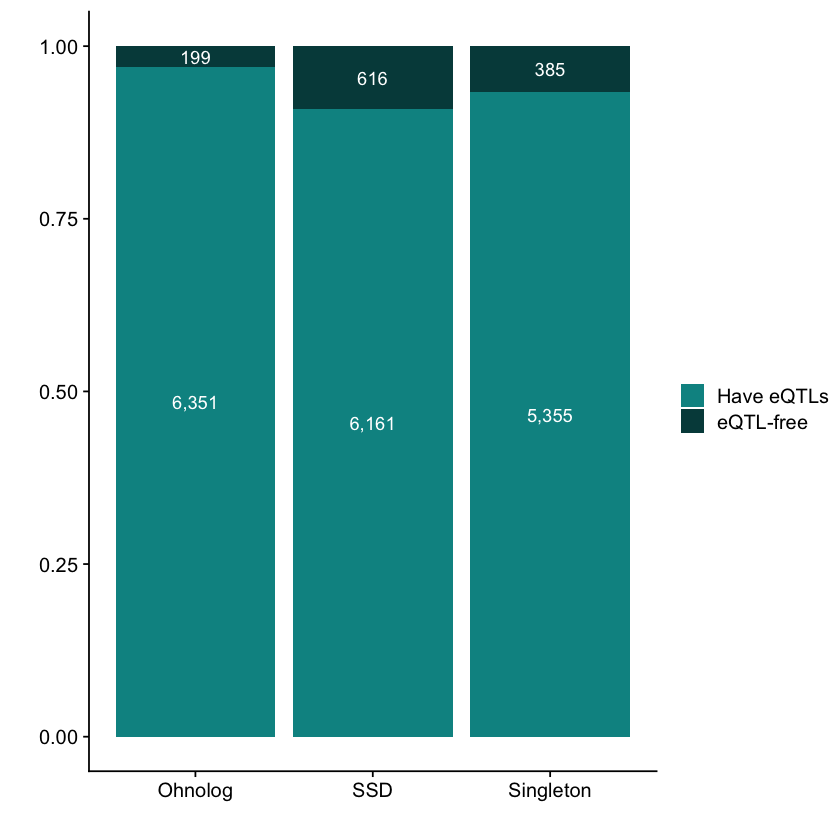

In [22]:
ohnolog_bar_chart_metasoft <- ggplot(data=melt(table(genesWitheQTLTissueCountMetasoft[,c("type","affected")])), aes(type, value)) +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    theme_cowplot() +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        limits=c("ohno", "SSD", "singleton"),
        labels=c("Ohnolog", "SSD", "Singleton")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

ohnolog_bar_chart_metasoft

## CNVRs (Zarrei et. al CNV map)

### Proportion affected by eQTLs

##### Bonferroni-corrected

In [23]:
genesWitheQTLTissueCountBonferroni <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndCNVZarreiStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9533                      Mean   : 7.669   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :24920039

In [24]:
genesWitheQTLTissueCountBonferroni$affected <- 'N'
genesWitheQTLTissueCountBonferroni[ which(genesWitheQTLTissueCountBonferroni$affectedTissues > 0),]$affected <- 'Y'

In [25]:
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9533                      Mean   : 7.669   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :24920039

In [26]:
table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])

   affected
CNV    N    Y
  N 2426 9517
  Y  903 6221

In [27]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountBonferroni[, c("CNV", "affected")])
X-squared = 180.1, df = 1, p-value < 2.2e-16


   affected
CNV    N    Y
  N 2426 9517
  Y  903 6221

,N,Y
N,2085.186,9857.814
Y,1243.814,5880.186


   affected
CNV         N         Y
  N  13.43972 -13.43972
  Y -13.43972  13.43972

In [28]:
round(9517/(9517+2426), 3)

[1] 0.797

In [29]:
round(6221/(6221+903), 3)

[1] 0.873

In [30]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 4.616864e-40

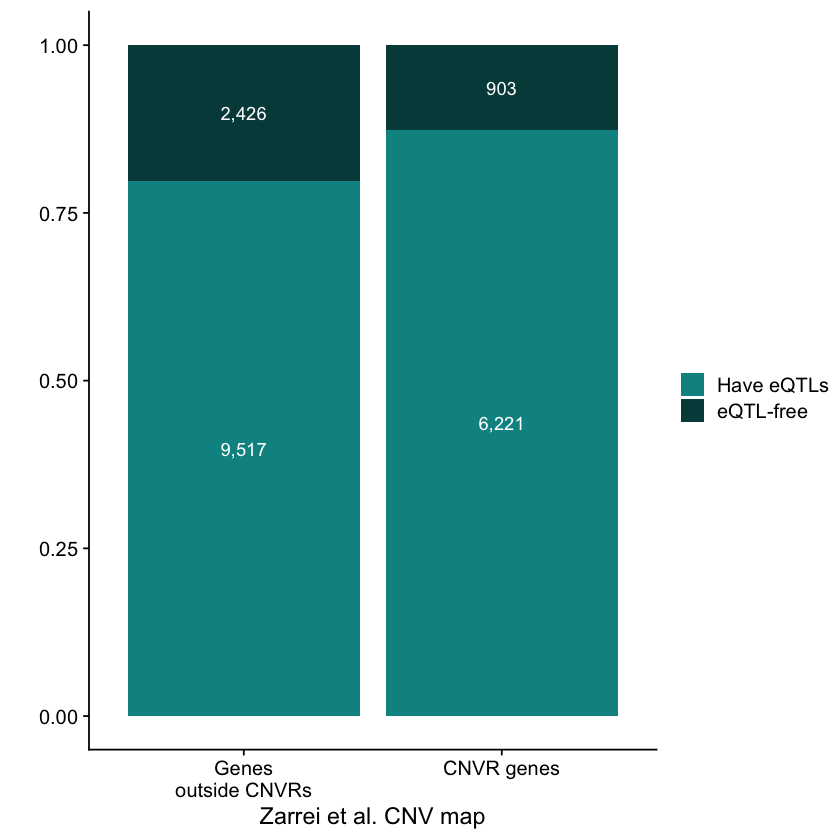

In [31]:
cnvr_bar_chart_bonferroni <- ggplot(data=melt(table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])), aes(CNV, value)) +
    theme_cowplot() +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    scale_y_continuous(name="") +
    scale_x_discrete(name="Zarrei et al. CNV map",
        breaks=c("N", "Y"),
        labels=c("Genes\noutside CNVRs", "CNVR genes")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

cnvr_bar_chart_bonferroni

##### Metasoft

In [32]:
genesWitheQTLTissueCountMetasoft <- read.csv("../../outputFiles/genesWitheQTLTissueCountMetasoftAndCNVZarreiStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.:10.00   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median :34.00   Median :48.00   
 Mean   : 9533                      Mean   :28.96   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :249200395   Max

In [33]:
genesWitheQTLTissueCountMetasoft$affected <- 'N'
genesWitheQTLTissueCountMetasoft[ which(genesWitheQTLTissueCountMetasoft$affectedTissues > 0),]$affected <- 'Y'

In [34]:
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:19067       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4766   Class :character   1st Qu.:10.00   1st Qu.:46.00   
 Median : 9533   Mode  :character   Median :34.00   Median :48.00   
 Mean   : 9533                      Mean   :28.96   Mean   :41.44   
 3rd Qu.:14300                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :19066                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand        
 Length:19067       Min.   :     5810   Min.   :    31427   Min.   :-1.00000  
 Class :character   1st Qu.: 31743292   1st Qu.: 31804066   1st Qu.:-1.00000  
 Mode  :character   Median : 58328984   Median : 58419584   Median : 1.00000  
                    Mean   : 74432773   Mean   : 74500717   Mean   : 0.01243  
                    3rd Qu.:111205142   3rd Qu.:111303315   3rd Qu.: 1.00000  
                    Max.   :249200395   Max

In [35]:
table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])

   affected
CNV     N     Y
  N   846 11097
  Y   354  6770

In [36]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountMetasoft[, c("CNV", "affected")])
X-squared = 33.473, df = 1, p-value = 7.225e-09


   affected
CNV     N     Y
  N   846 11097
  Y   354  6770

,N,Y
N,751.6442,11191.356
Y,448.3558,6675.644


   affected
CNV         N         Y
  N  5.816437 -5.816437
  Y -5.816437  5.816437

In [37]:
round(11097/(11097+846), 3)

[1] 0.929

In [38]:
round(6770/(6770+354), 3)

[1] 0.95

In [39]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 7.224744e-08

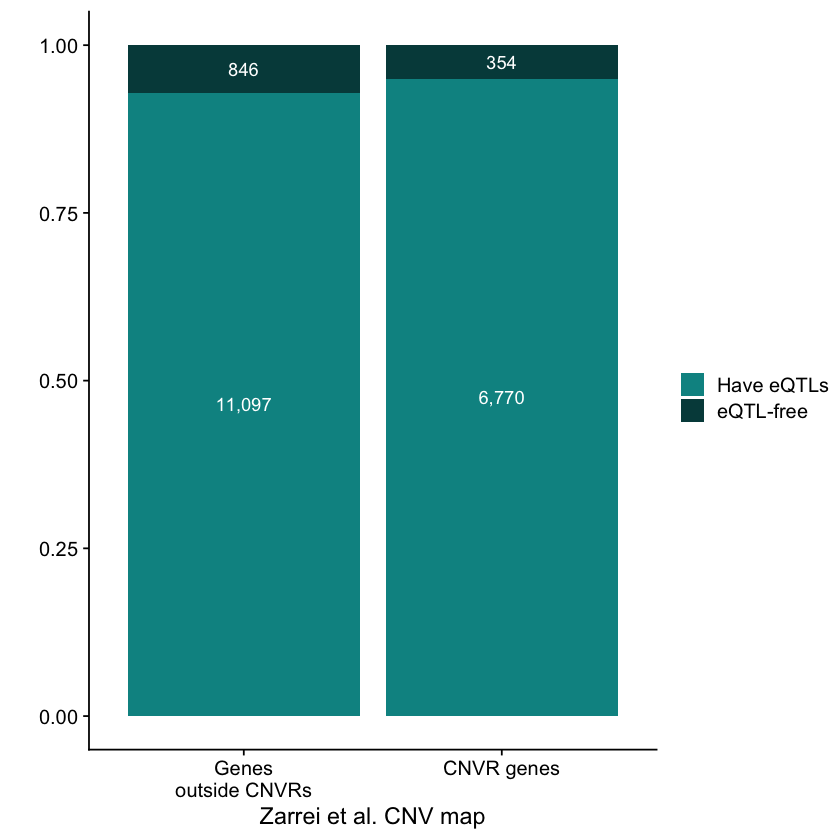

In [40]:
cnvr_bar_chart_metasoft <- ggplot(data=melt(table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])), aes(CNV, value)) +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    theme_cowplot() +
    scale_y_continuous(name="") +
    scale_x_discrete(name="Zarrei et al. CNV map",
        breaks=c("N", "Y"),
        labels=c("Genes\noutside CNVRs", "CNVR genes")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

cnvr_bar_chart_metasoft

## CNV-affected genes (ExAC CNV data)

### Proportion affected by eQTLs

##### Bonferroni-corrected

In [41]:
genesWitheQTLTissueCountBonferroni <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndCNVExACStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:15150       Min.   : 0.000   Min.   : 1      
 1st Qu.: 3787   Class :character   1st Qu.: 1.000   1st Qu.:47      
 Median : 7574   Mode  :character   Median : 4.000   Median :48      
 Mean   : 7574                      Mean   : 7.705   Mean   :43      
 3rd Qu.:11362                      3rd Qu.:10.000   3rd Qu.:48      
 Max.   :15149                      Max.   :48.000   Max.   :48      
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand         
 Min.   : 1.000   Min.   :    38814   Min.   :    46870   Min.   :-1.000000  
 1st Qu.: 4.000   1st Qu.: 32553918   1st Qu.: 32617152   1st Qu.:-1.000000  
 Median : 9.000   Median : 58707320   Median : 58857424   Median : 1.000000  
 Mean   : 9.711   Mean   : 74994357   Mean   : 75066462   Mean   : 0.004356  
 3rd Qu.:16.000   3rd Qu.:111764211   3rd Qu.:111836079   3rd Qu.: 1.000000  
 Max.   :22.000   Max.   :249200395   Max.

In [42]:
genesWitheQTLTissueCountBonferroni$affected <- 'N'
genesWitheQTLTissueCountBonferroni[ which(genesWitheQTLTissueCountBonferroni$affectedTissues > 0),]$affected <- 'Y'

In [43]:
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:15150       Min.   : 0.000   Min.   : 1      
 1st Qu.: 3787   Class :character   1st Qu.: 1.000   1st Qu.:47      
 Median : 7574   Mode  :character   Median : 4.000   Median :48      
 Mean   : 7574                      Mean   : 7.705   Mean   :43      
 3rd Qu.:11362                      3rd Qu.:10.000   3rd Qu.:48      
 Max.   :15149                      Max.   :48.000   Max.   :48      
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand         
 Min.   : 1.000   Min.   :    38814   Min.   :    46870   Min.   :-1.000000  
 1st Qu.: 4.000   1st Qu.: 32553918   1st Qu.: 32617152   1st Qu.:-1.000000  
 Median : 9.000   Median : 58707320   Median : 58857424   Median : 1.000000  
 Mean   : 9.711   Mean   : 74994357   Mean   : 75066462   Mean   : 0.004356  
 3rd Qu.:16.000   3rd Qu.:111764211   3rd Qu.:111836079   3rd Qu.: 1.000000  
 Max.   :22.000   Max.   :249200395   Max.

In [44]:
table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])

   affected
CNV     N     Y
  N   397  1416
  Y  1996 11341

In [45]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountBonferroni[, c("CNV", "affected")])
X-squared = 57.135, df = 1, p-value = 4.07e-14


   affected
CNV     N     Y
  N   397  1416
  Y  1996 11341

,N,Y
N,286.3702,1526.63
Y,2106.6298,11230.37


   affected
CNV         N         Y
  N  7.593069 -7.593069
  Y -7.593069  7.593069

In [46]:
round(1416/(1416+397), 3)

[1] 0.781

In [47]:
round(11341/(11341+1996), 3)

[1] 0.85

In [48]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 4.069563e-13

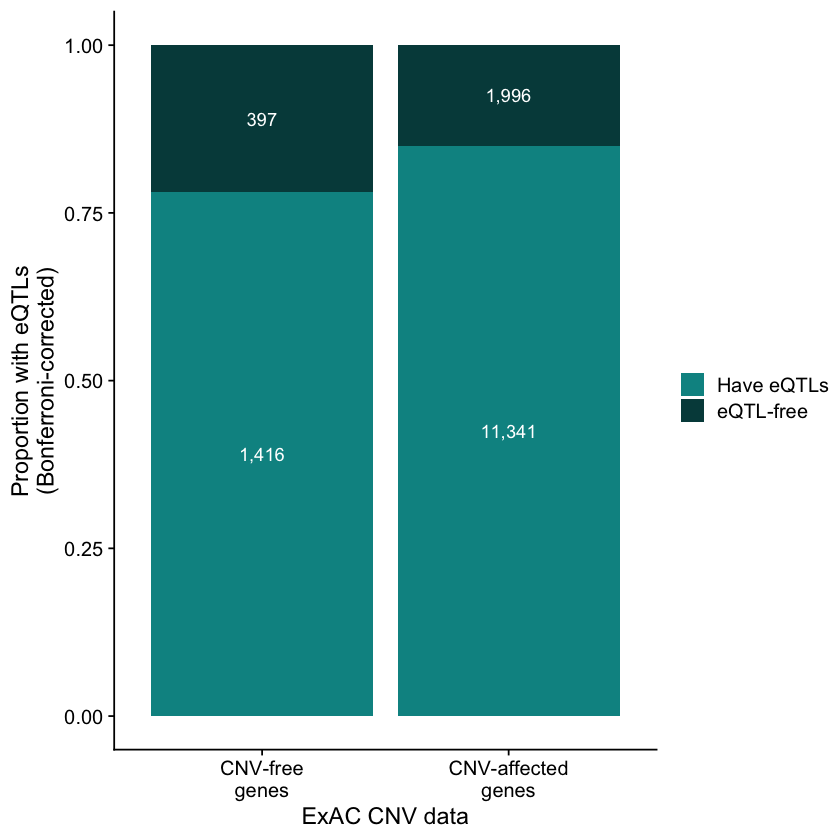

In [49]:
cnv_exac_bar_chart_bonferroni <- ggplot(data=melt(table(genesWitheQTLTissueCountBonferroni[,c("CNV","affected")])), aes(CNV, value)) +
    theme_cowplot() +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    scale_y_continuous(name="Proportion with eQTLs\n(Bonferroni-corrected)") +
    scale_x_discrete(name="ExAC CNV data",
        breaks=c("N", "Y"),
        labels=c("CNV-free\ngenes", "CNV-affected\ngenes")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

cnv_exac_bar_chart_bonferroni

##### Metasoft

In [50]:
genesWitheQTLTissueCountMetasoft <- read.csv("../../outputFiles/genesWitheQTLTissueCountMetasoftAndCNVExACStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:15150       Min.   : 0.00   Min.   : 1      
 1st Qu.: 3787   Class :character   1st Qu.:13.00   1st Qu.:47      
 Median : 7574   Mode  :character   Median :36.00   Median :48      
 Mean   : 7574                      Mean   :30.01   Mean   :43      
 3rd Qu.:11362                      3rd Qu.:47.00   3rd Qu.:48      
 Max.   :15149                      Max.   :48.00   Max.   :48      
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand         
 Min.   : 1.000   Min.   :    38814   Min.   :    46870   Min.   :-1.000000  
 1st Qu.: 4.000   1st Qu.: 32553918   1st Qu.: 32617152   1st Qu.:-1.000000  
 Median : 9.000   Median : 58707320   Median : 58857424   Median : 1.000000  
 Mean   : 9.711   Mean   : 74994357   Mean   : 75066462   Mean   : 0.004356  
 3rd Qu.:16.000   3rd Qu.:111764211   3rd Qu.:111836079   3rd Qu.: 1.000000  
 Max.   :22.000   Max.   :249200395   Max.   :249

In [51]:
genesWitheQTLTissueCountMetasoft$affected <- 'N'
genesWitheQTLTissueCountMetasoft[ which(genesWitheQTLTissueCountMetasoft$affectedTissues > 0),]$affected <- 'Y'

In [52]:
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:15150       Min.   : 0.00   Min.   : 1      
 1st Qu.: 3787   Class :character   1st Qu.:13.00   1st Qu.:47      
 Median : 7574   Mode  :character   Median :36.00   Median :48      
 Mean   : 7574                      Mean   :30.01   Mean   :43      
 3rd Qu.:11362                      3rd Qu.:47.00   3rd Qu.:48      
 Max.   :15149                      Max.   :48.00   Max.   :48      
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand         
 Min.   : 1.000   Min.   :    38814   Min.   :    46870   Min.   :-1.000000  
 1st Qu.: 4.000   1st Qu.: 32553918   1st Qu.: 32617152   1st Qu.:-1.000000  
 Median : 9.000   Median : 58707320   Median : 58857424   Median : 1.000000  
 Mean   : 9.711   Mean   : 74994357   Mean   : 75066462   Mean   : 0.004356  
 3rd Qu.:16.000   3rd Qu.:111764211   3rd Qu.:111836079   3rd Qu.: 1.000000  
 Max.   :22.000   Max.   :249200395   Max.   :249

In [53]:
table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])

   affected
CNV     N     Y
  N    97  1716
  Y   568 12769

In [54]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountMetasoft[, c("CNV", "affected")])
X-squared = 4.2738, df = 1, p-value = 0.0387


   affected
CNV     N     Y
  N    97  1716
  Y   568 12769

,N,Y
N,79.58053,1733.419
Y,585.41947,12751.581


   affected
CNV         N         Y
  N  2.128413 -2.128413
  Y -2.128413  2.128413

In [55]:
round(1716/(1716+97), 3)

[1] 0.946

In [56]:
round(12769/(12769+568), 3)

[1] 0.957

In [57]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 0.3870401

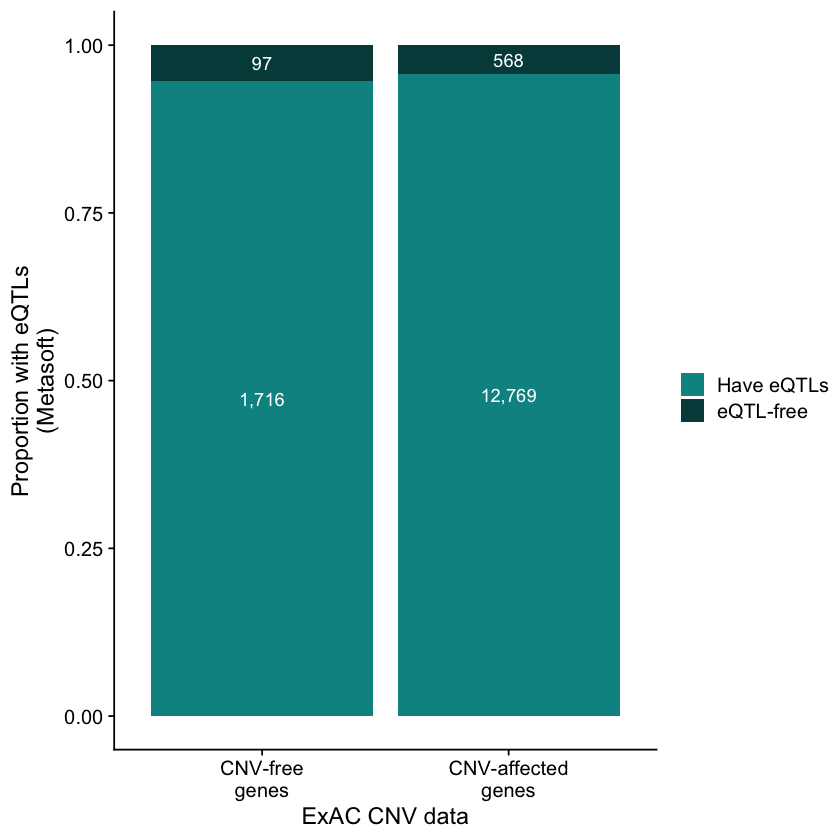

In [58]:
cnv_exac_bar_chart_metasoft <- ggplot(data=melt(table(genesWitheQTLTissueCountMetasoft[,c("CNV","affected")])), aes(CNV, value)) +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    theme_cowplot() +
    scale_y_continuous(name="Proportion with eQTLs\n(Metasoft)") +
    scale_x_discrete(name="ExAC CNV data",
        breaks=c("N", "Y"),
        labels=c("CNV-free\ngenes", "CNV-affected\ngenes")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

cnv_exac_bar_chart_metasoft

## Haploinsufficient genes (ExAC data)

### Proportion affected by eQTLs

##### Bonferroni-corrected

In [59]:
genesWitheQTLTissueCountBonferroni <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndHaploStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:17045       Min.   : 0.000   Min.   : 1.0    
 1st Qu.: 4261   Class :character   1st Qu.: 1.000   1st Qu.:47.0    
 Median : 8522   Mode  :character   Median : 4.000   Median :48.0    
 Mean   : 8522                      Mean   : 7.881   Mean   :42.5    
 3rd Qu.:12783                      3rd Qu.:11.000   3rd Qu.:48.0    
 Max.   :17044                      Max.   :48.000   Max.   :48.0    
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand       
 Min.   : 1.000   Min.   :     5810   Min.   :    31427   Min.   :-1.0000  
 1st Qu.: 4.000   1st Qu.: 31730576   1st Qu.: 31783437   1st Qu.:-1.0000  
 Median :10.000   Median : 58152564   Median : 58190520   Median : 1.0000  
 Mean   : 9.828   Mean   : 74468419   Mean   : 74538732   Mean   : 0.0044  
 3rd Qu.:16.000   3rd Qu.:111222977   3rd Qu.:111314290   3rd Qu.: 1.0000  
 Max.   :22.000   Max.   :249200395   Max.   :24921414

In [60]:
genesWitheQTLTissueCountBonferroni$affected <- 'N'
genesWitheQTLTissueCountBonferroni[ which(genesWitheQTLTissueCountBonferroni$affectedTissues > 0),]$affected <- 'Y'

In [61]:
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:17045       Min.   : 0.000   Min.   : 1.0    
 1st Qu.: 4261   Class :character   1st Qu.: 1.000   1st Qu.:47.0    
 Median : 8522   Mode  :character   Median : 4.000   Median :48.0    
 Mean   : 8522                      Mean   : 7.881   Mean   :42.5    
 3rd Qu.:12783                      3rd Qu.:11.000   3rd Qu.:48.0    
 Max.   :17044                      Max.   :48.000   Max.   :48.0    
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand       
 Min.   : 1.000   Min.   :     5810   Min.   :    31427   Min.   :-1.0000  
 1st Qu.: 4.000   1st Qu.: 31730576   1st Qu.: 31783437   1st Qu.:-1.0000  
 Median :10.000   Median : 58152564   Median : 58190520   Median : 1.0000  
 Mean   : 9.828   Mean   : 74468419   Mean   : 74538732   Mean   : 0.0044  
 3rd Qu.:16.000   3rd Qu.:111222977   3rd Qu.:111314290   3rd Qu.: 1.0000  
 Max.   :22.000   Max.   :249200395   Max.   :24921414

In [62]:
table(genesWitheQTLTissueCountBonferroni[,c("haplo","affected")])

     affected
haplo     N     Y
    N  2233 11820
    Y   486  2506

In [63]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountBonferroni[,c("haplo","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountBonferroni[, c("haplo", "affected")])
X-squared = 0.20427, df = 1, p-value = 0.6513


     affected
haplo     N     Y
    N  2233 11820
    Y   486  2506

,N,Y
N,2241.7194,11811.281
Y,477.2806,2514.719


     affected
haplo          N          Y
    N -0.4794565  0.4794565
    Y  0.4794565 -0.4794565

In [64]:
round(11820/(11820+2233), 3)

[1] 0.841

In [65]:
round(2506/(2506+486), 3)

[1] 0.838

In [66]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 1

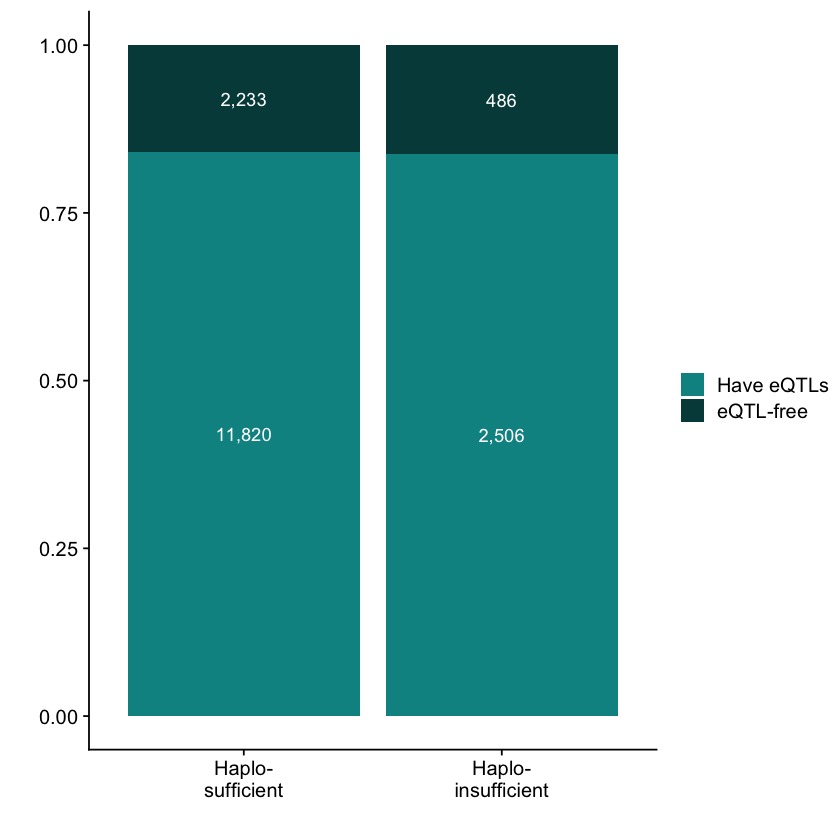

In [67]:
haplo_bar_chart_bonferroni <- ggplot(data=melt(table(genesWitheQTLTissueCountBonferroni[,c("haplo","affected")])), aes(haplo, value)) +
    theme_cowplot() +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("Haplo-\nsufficient", "Haplo-\ninsufficient")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

haplo_bar_chart_bonferroni

##### Metasoft

In [68]:
genesWitheQTLTissueCountMetasoft <- read.csv("../../outputFiles/genesWitheQTLTissueCountMetasoftAndHaploStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:17045       Min.   : 0.00   Min.   : 1.0    
 1st Qu.: 4261   Class :character   1st Qu.:12.00   1st Qu.:47.0    
 Median : 8522   Mode  :character   Median :36.00   Median :48.0    
 Mean   : 8522                      Mean   :29.93   Mean   :42.5    
 3rd Qu.:12783                      3rd Qu.:47.00   3rd Qu.:48.0    
 Max.   :17044                      Max.   :48.00   Max.   :48.0    
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand       
 Min.   : 1.000   Min.   :     5810   Min.   :    31427   Min.   :-1.0000  
 1st Qu.: 4.000   1st Qu.: 31730576   1st Qu.: 31783437   1st Qu.:-1.0000  
 Median :10.000   Median : 58152564   Median : 58190520   Median : 1.0000  
 Mean   : 9.828   Mean   : 74468419   Mean   : 74538732   Mean   : 0.0044  
 3rd Qu.:16.000   3rd Qu.:111222977   3rd Qu.:111314290   3rd Qu.: 1.0000  
 Max.   :22.000   Max.   :249200395   Max.   :249214145   Max

In [69]:
genesWitheQTLTissueCountMetasoft$affected <- 'N'
genesWitheQTLTissueCountMetasoft[ which(genesWitheQTLTissueCountMetasoft$affectedTissues > 0),]$affected <- 'Y'

In [70]:
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:17045       Min.   : 0.00   Min.   : 1.0    
 1st Qu.: 4261   Class :character   1st Qu.:12.00   1st Qu.:47.0    
 Median : 8522   Mode  :character   Median :36.00   Median :48.0    
 Mean   : 8522                      Mean   :29.93   Mean   :42.5    
 3rd Qu.:12783                      3rd Qu.:47.00   3rd Qu.:48.0    
 Max.   :17044                      Max.   :48.00   Max.   :48.0    
 Chromosome.Name  Gene.Start..bp.     Gene.End..bp.           Strand       
 Min.   : 1.000   Min.   :     5810   Min.   :    31427   Min.   :-1.0000  
 1st Qu.: 4.000   1st Qu.: 31730576   1st Qu.: 31783437   1st Qu.:-1.0000  
 Median :10.000   Median : 58152564   Median : 58190520   Median : 1.0000  
 Mean   : 9.828   Mean   : 74468419   Mean   : 74538732   Mean   : 0.0044  
 3rd Qu.:16.000   3rd Qu.:111222977   3rd Qu.:111314290   3rd Qu.: 1.0000  
 Max.   :22.000   Max.   :249200395   Max.   :249214145   Max

In [71]:
table(genesWitheQTLTissueCountMetasoft[,c("haplo","affected")])

     affected
haplo     N     Y
    N   794 13259
    Y    37  2955

In [72]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountMetasoft[,c("haplo","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountMetasoft[, c("haplo", "affected")])
X-squared = 102.66, df = 1, p-value < 2.2e-16


     affected
haplo     N     Y
    N   794 13259
    Y    37  2955

,N,Y
N,685.1301,13367.87
Y,145.8699,2846.13


     affected
haplo        N        Y
    N  10.1787 -10.1787
    Y -10.1787  10.1787

In [73]:
round(13259/(13259+794), 3)

[1] 0.943

In [74]:
round(2955/(2955+37), 3)

[1] 0.988

In [75]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 3.986076e-23

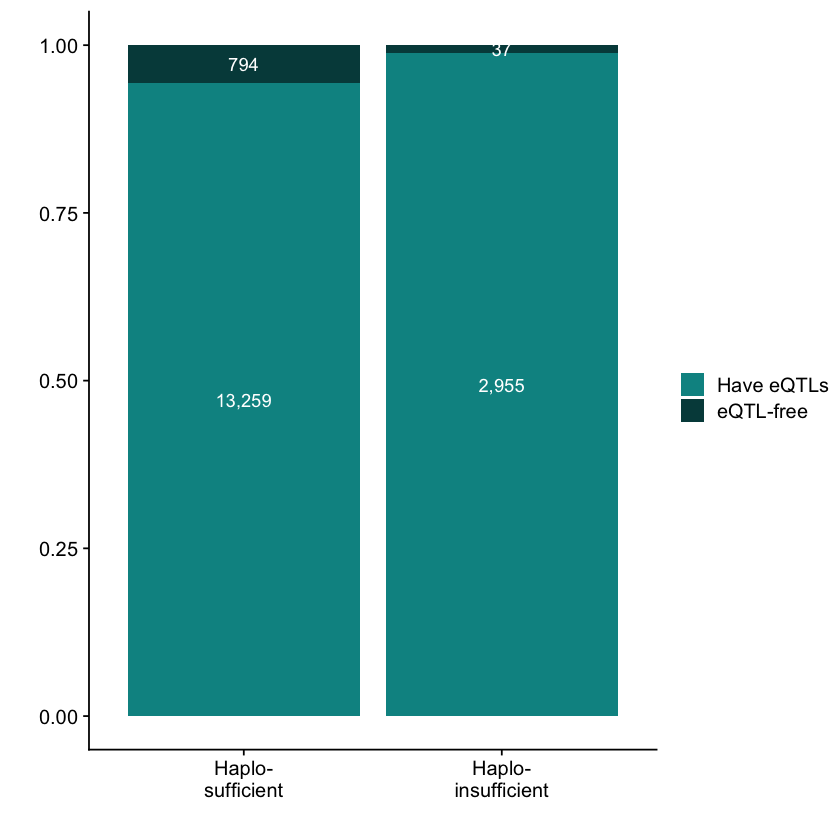

In [76]:
haplo_bar_chart_metasoft <- ggplot(data=melt(table(genesWitheQTLTissueCountMetasoft[,c("haplo","affected")])), aes(haplo, value)) +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    theme_cowplot() +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("Haplo-\nsufficient", "Haplo-\ninsufficient")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

haplo_bar_chart_metasoft

## Copy number conserved genes

### Proportion affected by eQTLs

##### Bonferroni-corrected

In [77]:
genesWitheQTLTissueCountBonferroni <- read.csv("../../outputFiles/genesWitheQTLTissueCountBonferroniAndCCNStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:18402       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4600   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9200   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9200                      Mean   : 7.753   Mean   :42.07   
 3rd Qu.:13801                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :18401                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand         
 Length:18402       Min.   :     5810   Min.   :    31427   Min.   :-1.000000  
 Class :character   1st Qu.: 31731036   1st Qu.: 31788800   1st Qu.:-1.000000  
 Mode  :character   Median : 58261514   Median : 58338500   Median : 1.000000  
                    Mean   : 74435114   Mean   : 74504737   Mean   : 0.008912  
                    3rd Qu.:111309615   3rd Qu.:111371553   3rd Qu.: 1.000000  
                    Max.   :24

In [78]:
genesWitheQTLTissueCountBonferroni$affected <- 'N'
genesWitheQTLTissueCountBonferroni[ which(genesWitheQTLTissueCountBonferroni$affectedTissues > 0),]$affected <- 'Y'

In [79]:
summary(genesWitheQTLTissueCountBonferroni)

       X         Ensembl.Gene.ID    affectedTissues  expressedTissues
 Min.   :    0   Length:18402       Min.   : 0.000   Min.   : 1.00   
 1st Qu.: 4600   Class :character   1st Qu.: 1.000   1st Qu.:46.00   
 Median : 9200   Mode  :character   Median : 4.000   Median :48.00   
 Mean   : 9200                      Mean   : 7.753   Mean   :42.07   
 3rd Qu.:13801                      3rd Qu.:10.000   3rd Qu.:48.00   
 Max.   :18401                      Max.   :48.000   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand         
 Length:18402       Min.   :     5810   Min.   :    31427   Min.   :-1.000000  
 Class :character   1st Qu.: 31731036   1st Qu.: 31788800   1st Qu.:-1.000000  
 Mode  :character   Median : 58261514   Median : 58338500   Median : 1.000000  
                    Mean   : 74435114   Mean   : 74504737   Mean   : 0.008912  
                    3rd Qu.:111309615   3rd Qu.:111371553   3rd Qu.: 1.000000  
                    Max.   :24

In [80]:
table(genesWitheQTLTissueCountBonferroni[,c("CCN","affected")])

   affected
CCN    N    Y
  N 2109 9361
  Y  955 5977

In [81]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountBonferroni[,c("CCN","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountBonferroni[, c("CCN", "affected")])
X-squared = 65.845, df = 1, p-value = 4.877e-16


   affected
CCN    N    Y
  N 2109 9361
  Y  955 5977

,N,Y
N,1909.797,9560.203
Y,1154.203,5777.797


   affected
CCN         N         Y
  N  8.134937 -8.134937
  Y -8.134937  8.134937

In [82]:
round(9361/(9361+2109), 3)

[1] 0.816

In [83]:
round(5977/(5977+955), 3)

[1] 0.862

In [84]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 4.877149e-15

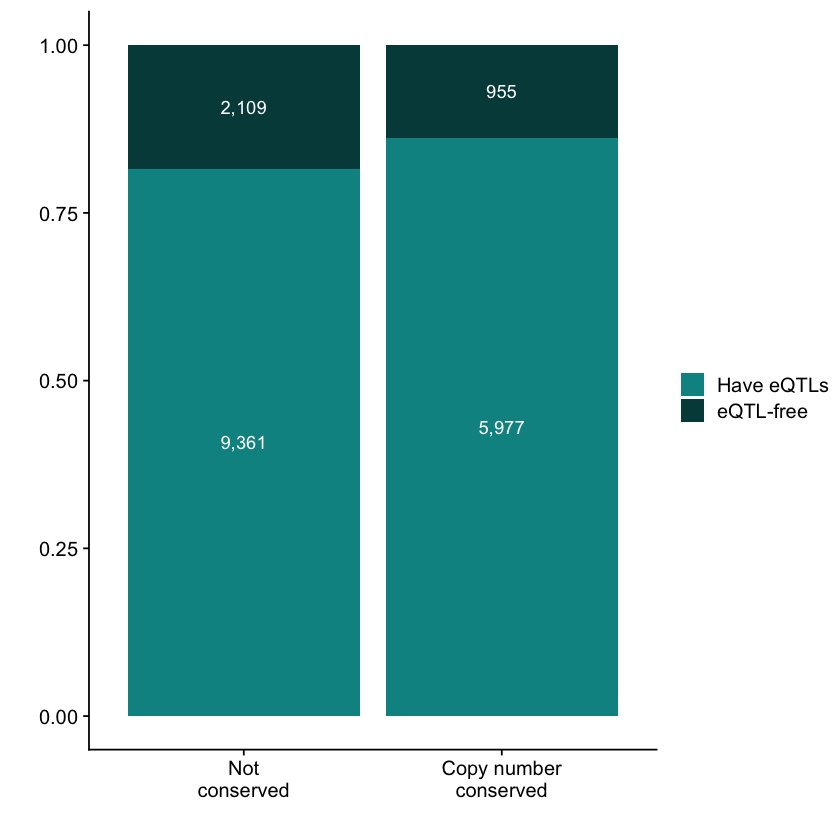

In [85]:
ccn_bar_chart_bonferroni <- ggplot(data=melt(table(genesWitheQTLTissueCountBonferroni[,c("CCN","affected")])), aes(CCN, value)) +
    theme_cowplot() +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("Not\nconserved", "Copy number\nconserved")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

ccn_bar_chart_bonferroni

##### Metasoft

In [86]:
genesWitheQTLTissueCountMetasoft <- read.csv("../../outputFiles/genesWitheQTLTissueCountMetasoftAndCCNStatus.csv", sep="\t")
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:18402       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4600   Class :character   1st Qu.:11.00   1st Qu.:46.00   
 Median : 9200   Mode  :character   Median :35.00   Median :48.00   
 Mean   : 9200                      Mean   :29.41   Mean   :42.07   
 3rd Qu.:13801                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :18401                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand         
 Length:18402       Min.   :     5810   Min.   :    31427   Min.   :-1.000000  
 Class :character   1st Qu.: 31731036   1st Qu.: 31788800   1st Qu.:-1.000000  
 Mode  :character   Median : 58261514   Median : 58338500   Median : 1.000000  
                    Mean   : 74435114   Mean   : 74504737   Mean   : 0.008912  
                    3rd Qu.:111309615   3rd Qu.:111371553   3rd Qu.: 1.000000  
                    Max.   :249200395

In [87]:
genesWitheQTLTissueCountMetasoft$affected <- 'N'
genesWitheQTLTissueCountMetasoft[ which(genesWitheQTLTissueCountMetasoft$affectedTissues > 0),]$affected <- 'Y'

In [88]:
summary(genesWitheQTLTissueCountMetasoft)

       X         Ensembl.Gene.ID    affectedTissues expressedTissues
 Min.   :    0   Length:18402       Min.   : 0.00   Min.   : 1.00   
 1st Qu.: 4600   Class :character   1st Qu.:11.00   1st Qu.:46.00   
 Median : 9200   Mode  :character   Median :35.00   Median :48.00   
 Mean   : 9200                      Mean   :29.41   Mean   :42.07   
 3rd Qu.:13801                      3rd Qu.:47.00   3rd Qu.:48.00   
 Max.   :18401                      Max.   :48.00   Max.   :48.00   
 Chromosome.Name    Gene.Start..bp.     Gene.End..bp.           Strand         
 Length:18402       Min.   :     5810   Min.   :    31427   Min.   :-1.000000  
 Class :character   1st Qu.: 31731036   1st Qu.: 31788800   1st Qu.:-1.000000  
 Mode  :character   Median : 58261514   Median : 58338500   Median : 1.000000  
                    Mean   : 74435114   Mean   : 74504737   Mean   : 0.008912  
                    3rd Qu.:111309615   3rd Qu.:111371553   3rd Qu.: 1.000000  
                    Max.   :249200395

In [89]:
table(genesWitheQTLTissueCountMetasoft[,c("CCN","affected")])

   affected
CCN     N     Y
  N   815 10655
  Y   192  6740

In [90]:
(Xsq <- chisq.test(table(genesWitheQTLTissueCountMetasoft[,c("CCN","affected")])))  # Prints test summary
Xsq$observed   # observed counts
Xsq$expected   # expected counts under the null
Xsq$stdres     # standardized residuals


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(genesWitheQTLTissueCountMetasoft[, c("CCN", "affected")])
X-squared = 156.18, df = 1, p-value < 2.2e-16


   affected
CCN     N     Y
  N   815 10655
  Y   192  6740

,N,Y
N,627.6649,10842.335
Y,379.3351,6552.665


   affected
CCN        N        Y
  N  12.5308 -12.5308
  Y -12.5308  12.5308

In [91]:
round(10655/(10655+815), 3)

[1] 0.929

In [92]:
round(6740/(6740+192), 3)

[1] 0.972

In [93]:
p.adjust(Xsq$p.value, method="bonferroni", n=10)

[1] 7.717936e-35

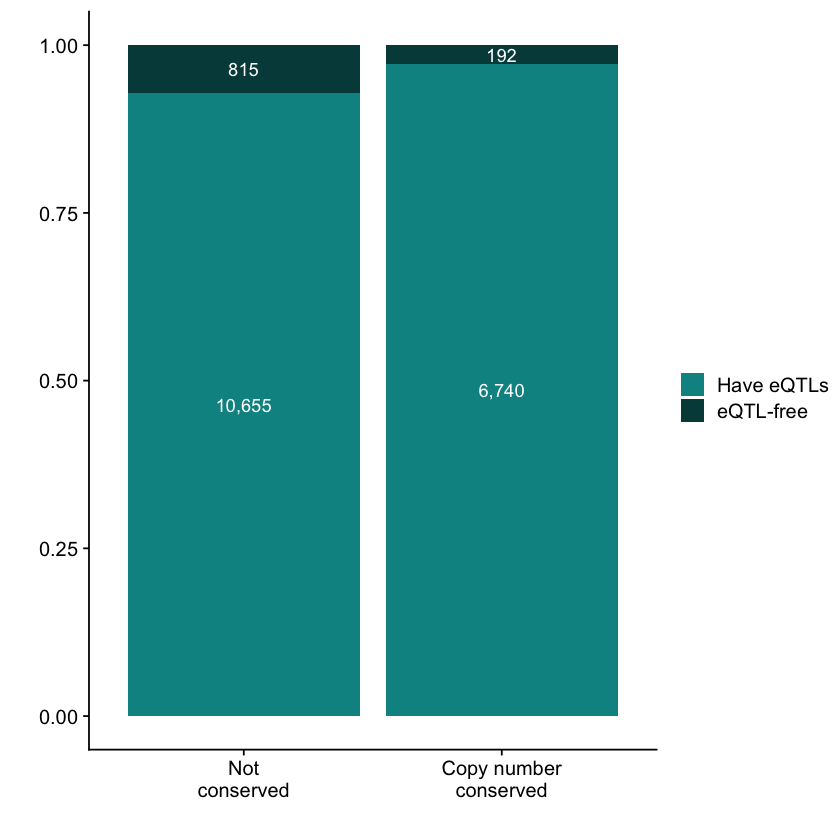

In [94]:
ccn_bar_chart_metasoft <- ggplot(data=melt(table(genesWitheQTLTissueCountMetasoft[,c("CCN","affected")])), aes(CCN, value)) +
    geom_bar(aes(fill = affected), stat="identity", position="fill") +
    theme_cowplot() +
    scale_y_continuous(name="") +
    scale_x_discrete(name="",
        breaks=c("N", "Y"),
        labels=c("Not\nconserved", "Copy number\nconserved")) +
    scale_fill_manual(values=c("#009292", "#004949"),
        name="",
        breaks=c("Y", "N"),
        labels=c("Have eQTLs", "eQTL-free")) +
    geom_text(aes(label = prettyNum(value, big.mark=","),
               group=affected),
          vjust=0.5,
          stat='identity',
          colour = "white",
          position = position_fill(vjust = .5)) +
    theme(legend.position = "right")

ccn_bar_chart_metasoft

## Plot figure

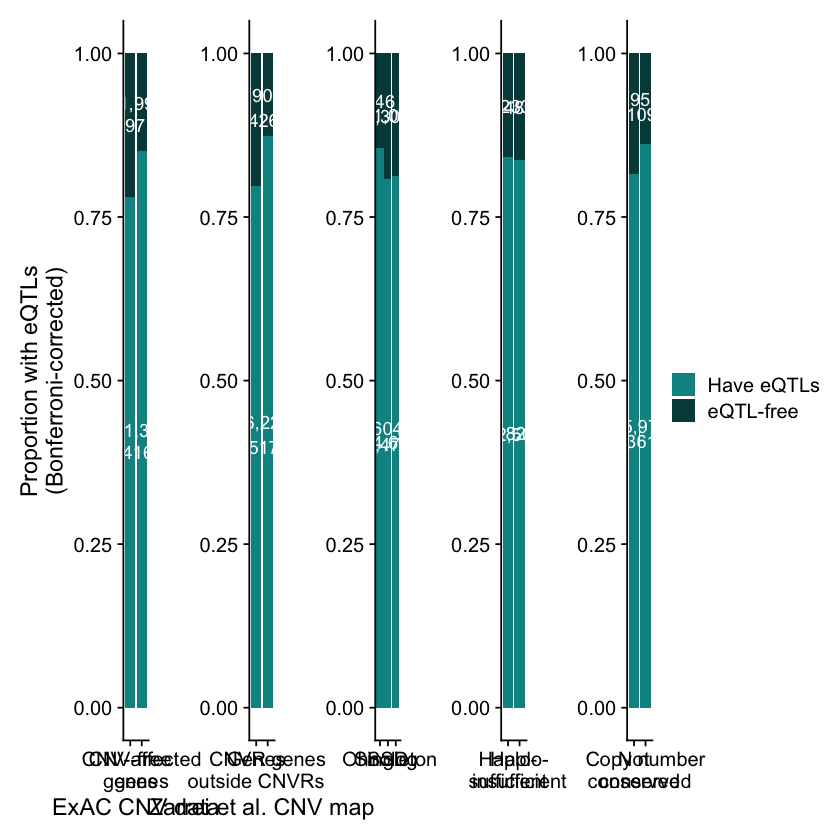

In [95]:
cnv_exac_bar_chart_bonferroni | cnvr_bar_chart_bonferroni | ohnolog_bar_chart_bonferroni | haplo_bar_chart_bonferroni | ccn_bar_chart_bonferroni | plot_layout(guides = 'collect')

In [96]:
ggsave('../../outputFiles/figures/eQTLEnrichmentGroupsBarChartBonferroni.svg', width=40, height=13, units="cm")

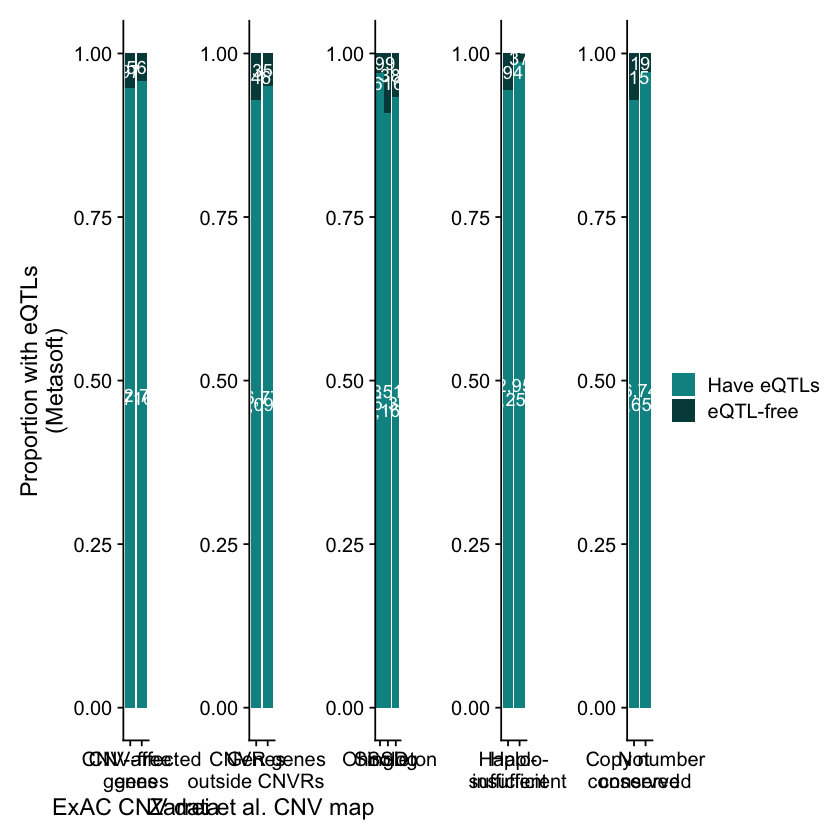

In [97]:
cnv_exac_bar_chart_metasoft | cnvr_bar_chart_metasoft | ohnolog_bar_chart_metasoft | haplo_bar_chart_metasoft | ccn_bar_chart_metasoft | plot_layout(guides = 'collect')

In [98]:
ggsave('../../outputFiles/figures/eQTLEnrichmentGroupsBarChartMetasoft.svg', width=40, height=13, units="cm")

In [99]:
ggsave('../../outputFiles/figures/eQTLEnrichmentGroupsBarChartMetasoft.pdf', width=40, height=13, units="cm")